<a href="https://colab.research.google.com/github/jindalk/pytorch_projects/blob/main/04_mnist_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning VAEs through MNIST

In [ ]:
# connect drive
from google.colab import drive
drive.mount("/content/drive")

# add custom lib path
import os, sys
sys.path.append("/content/drive/MyDrive/libs")

Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import umap

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

Load data

In [ ]:
#load data
data = datasets.mnist.MNIST(root="sample_data", download=True)

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data.data, data.targets, test_size = 0.2,
                                                                    random_state = 42, stratify = data.targets)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

Define model

In [ ]:
#define model

class VAE(nn.Module):

  #init creates the network structure
  def __init__(self, z_dim):
    super(VAE, self).__init__()

    #define a simple fully connected encoder to produce logvar and mean of the latent space
    self.z_dim = z_dim
    self.enc1 = nn.Linear(784, 400)
    self.enc_logvar = nn.Linear(400, z_dim)
    self.enc_mean = nn.Linear(400, z_dim)

    #define a simple fully connected decoder to reconstruct images
    self.dec1 = nn.Linear(z_dim, 400)
    self.dec2 = nn.Linear(400, 784)


  #setup encoding
  def encode(self, input):
    o1 = F.relu(self.enc1(input))
    o_logvar = self.enc_logvar(o1)
    o_mean = self.enc_mean(o1)
    return(o_mean, o_logvar)


  #setup decoding
  def decode(self, z):
    o1 = F.relu(self.dec1(z))
    o2 = torch.sigmoid(self.dec2(o1))
    return(o2)


  #reparam for differentiable z-sampling
  def reparam(self, mean, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return(mean + std*eps)

  #setup forward pass during training
  def forward(self, input):
    mean, logvar = self.encode(input.view(-1, 784))
    z = self.reparam(mean, logvar)
    recon_input = self.decode(z)

    return(recon_input, mean, logvar)


# ---- end VAE class ---- #

#define loss function
def loss_fn(input, recon_input, mean, logvar):
  kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
  recon_loss = F.binary_cross_entropy(recon_input, input.view(-1,784), reduction='sum')
  loss = kl_loss + recon_loss
  return(loss)

#and finally, setup training routine
def train(input_data_loader, model, optimizer, device):

  #set model to train
  model.train()
  loss_epoch = 0

  for data, _ in input_data_loader:
    data = data.to(device).float()/255.0
    optimizer.zero_grad()

    recon_batch, mean, logvar = model(data)
    loss = loss_fn(data, recon_batch, mean, logvar)
    loss.backward()
    loss_epoch += loss.item()

    optimizer.step()

  #return avg loss
  return(loss_epoch/len(input_data_loader.dataset))

In [ ]:
#define training params
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(z_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-3)

In [ ]:
losses = []

for epoch in range(0, epochs):
  loss = train(input_data_loader=train_loader,
               model=model,
               optimizer=optimizer,
               device=device)

  losses.append(loss)

  # Visualize results every few epochs
  if epoch % 10 == 0:
    print(f'Epoch: {epoch+1}; loss: {loss}')

Epoch: 1; loss: 105.49074533081054
Epoch: 11; loss: 105.00780711873372
Epoch: 21; loss: 104.59150784810384
Epoch: 31; loss: 104.26544742329915
Epoch: 41; loss: 103.98155317179362
Epoch: 51; loss: 103.79073696899414
Epoch: 61; loss: 103.62637212626139
Epoch: 71; loss: 103.47047956848145
Epoch: 81; loss: 103.30664762878418
Epoch: 91; loss: 103.18895378112794


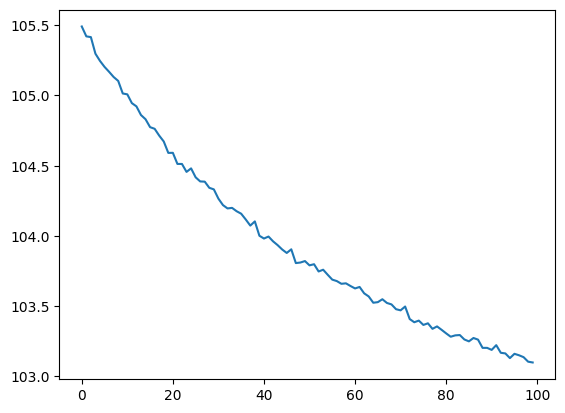

In [ ]:
plt.plot(np.array(losses))

NameError: name 'i' is not defined

In [ ]:
model.eval()

In [ ]:
with torch.no_grad():
  preds = model(test_data.to(device).float()/255.0)

preds_z = model.reparam(preds[1], preds[2])

In [ ]:
umap_dims = umap.UMAP().fit_transform(preds_z.cpu().float())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
umap_dims = pd.DataFrame(umap_dims, columns = ['x','y'])

In [ ]:
umap_dims['clust'] = test_labels.numpy()
umap_dims['clust'] = umap_dims['clust'].astype('category')

<Axes: xlabel='x', ylabel='y'>

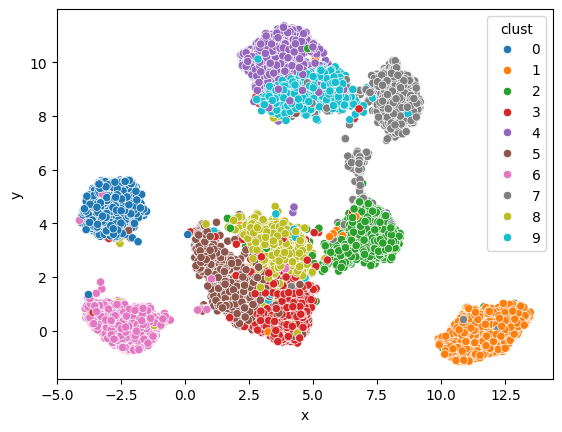

In [ ]:
sns.scatterplot(umap_dims, x='x', y='y', hue='clust')

In [ ]:
#define VAE model with CNN layers

class VAE_with_cnn(nn.Module):

  #init creates the network structure
  def __init__(self, z_dim):
    super(VAE, self).__init__()

    #define a simple fully connected encoder to produce logvar and mean of the latent space
    self.z_dim = z_dim
    self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 5, kernel_size = 4, padding=1)
    self.enc1 = nn.Linear(3645, 400)
    self.enc2 = nn.Linear(400, 100)
    self.enc_logvar = nn.Linear(100, z_dim)
    self.enc_mean = nn.Linear(100, z_dim)

    #define a simple fully connected decoder to reconstruct images
    self.dec1 = nn.Linear(z_dim, 100)
    self.dec2 = nn.Linear(z_dim, 200)
    self.dec3 = nn.Linear(200, 784)


  #setup encoding
  def encode(self, input):
    conv_out = F.relu(self.cnn1(input))
    flat = conv_out.view(conv_out.size(0), -1)
    hidden = F.relu(self.enc1(flat))
    hidden = F.relu(self.enc2(hidden))
    o_mean = self.enc_mean(hidden)
    o_logvar = self.enc_logvar(hidden)
    return(o_mean, o_logvar)


  #setup decoding
  def decode(self, z):
    hidden = F.relu(self.dec1(z))
    hidden = F.relu(self.dec2(hidden))
    # Final layer: output is flattened image; apply sigmoid so values are between 0 and 1.
    output = torch.sigmoid(self.dec3(hidden))
    return(output)


  #reparam for differentiable z-sampling
  def reparam(self, mean, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return(mean + std*eps)

  #setup forward pass during training
  def forward(self, input):
    mean, logvar = self.encode(input.view(-1, 784))
    z = self.reparam(mean, logvar)
    recon_input = self.decode(z)

    return(recon_input, mean, logvar)


# ---- end VAE class ---- #

In [ ]:
#define training params
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(z_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-3)

In [ ]:
losses_cnn = []

for epoch in range(0, epochs):
  loss = train(input_data_loader=train_loader,
               model=model,
               optimizer=optimizer,
               device=device)

  losses_cnn.append(loss)

  # Visualize results every few epochs
  if epoch % 10 == 0:
    print(f'Epoch: {epoch+1}; loss: {loss}')

Epoch: 1; loss: 142.2347236175537
Epoch: 11; loss: 109.9748193206787
Epoch: 21; loss: 107.39776620992025
Epoch: 31; loss: 106.18611840311686
Epoch: 41; loss: 105.43405183410644
Epoch: 51; loss: 104.91597523498535
Epoch: 61; loss: 104.55124680582682
Epoch: 71; loss: 104.24478336588541
Epoch: 81; loss: 103.9712304280599
Epoch: 91; loss: 103.82462341308593


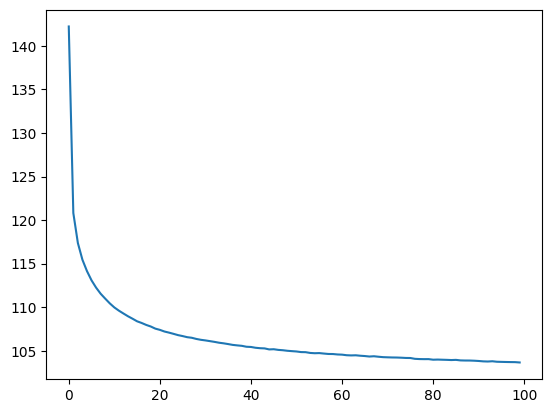

In [ ]:
plt.plot(np.array(losses_cnn))

In [ ]:
with torch.no_grad():
  preds_cnn = model(test_data.to(device).float()/255.0)

preds_cnn_z = model.reparam(preds_cnn[1], preds_cnn[2])

In [ ]:
umap_dims = umap.UMAP().fit_transform(preds_cnn_z.cpu().float())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
umap_dims = pd.DataFrame(umap_dims, columns = ['x','y'])

In [ ]:
umap_dims['clust'] = test_labels.numpy()
umap_dims['clust'] = umap_dims['clust'].astype('category')

<Axes: xlabel='x', ylabel='y'>

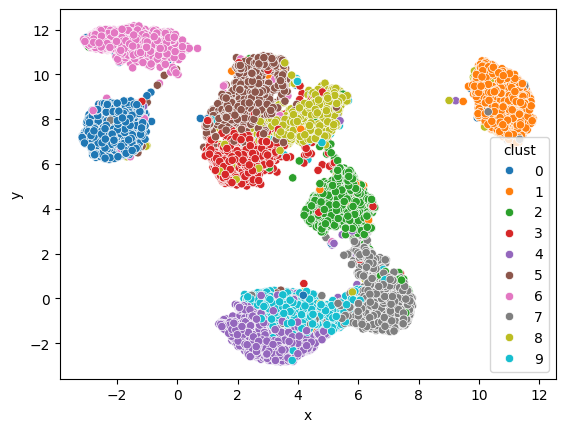

In [ ]:
sns.scatterplot(umap_dims, x='x', y='y', hue='clust')

In [ ]:
import pickle
pred_dict = {'vanilla':preds_z, 'vanilla_cnn':preds_cnn_z}

with open("/content/drive/MyDrive/single_cell/data/mnist_vae_outs.pkl","wb") as f:
  pickle.dump(pred_dict, f)

In [ ]:
with open("/content/drive/MyDrive/single_cell/data/mnist_vae_outs.pkl","rb") as f:
  pred_dict = pickle.load(f)

In [ ]:
pred_dict

{'vanilla': tensor([[ 1.3326, -0.7506, -0.3345,  ...,  0.5916, -0.4651, -0.2255],
         [-0.4895, -0.7255, -0.7112,  ...,  0.5767, -1.6822, -0.6789],
         [ 2.4747,  2.6509,  0.5271,  ..., -0.8253,  1.5751,  1.1705],
         ...,
         [-0.9091, -0.7090, -0.4800,  ..., -1.5594, -0.9830,  0.1378],
         [ 0.4020, -1.2241, -0.8278,  ..., -0.8582, -1.5281,  1.0304],
         [-1.6886,  1.7624, -0.9803,  ...,  2.2662, -1.1726,  0.3302]],
        device='cuda:0'),
 'vanilla_cnn': tensor([[ 1.1358,  0.8582, -0.1394,  ...,  1.2884,  0.2572, -0.0264],
         [ 1.2570, -0.6912,  1.9510,  ..., -1.6111,  0.5953, -0.1190],
         [-0.4436,  1.7290,  1.4677,  ...,  1.5236,  1.1361, -0.0342],
         ...,
         [ 0.7352, -1.4804, -1.1015,  ...,  0.1618,  1.2069,  0.7861],
         [ 2.5749, -0.1894, -2.2732,  ...,  1.7462,  0.9309, -0.5305],
         [ 0.8869, -1.6431,  2.8168,  ...,  0.0739, -1.0053, -0.5281]],
        device='cuda:0')}

In [ ]:
def loss_fn_kl_warmup(input, recon_input, mean, logvar, epoch, total_epochs):
  kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
  recon_loss = F.binary_cross_entropy(recon_input, input.view(-1,784), reduction='sum')
  kl_weight = min(0.6, epoch/total_epochs)
  loss = kl_weight * kl_loss + recon_loss
  return(loss)

def train_kl_warmup(input_data_loader, model, optimizer, device, epoch, total_epochs):

  #set model to train
  model.train()
  loss_epoch = 0

  for data, _ in input_data_loader:
    data = data.to(device).float()/255.0
    optimizer.zero_grad()

    recon_batch, mean, logvar = model(data)
    loss = loss_fn_kl_warmup(data, recon_batch, mean, logvar, epoch, total_epochs)
    loss.backward()
    loss_epoch += loss.item()

    optimizer.step()

  #return avg loss
  return(loss_epoch/len(input_data_loader.dataset))

In [ ]:
#define training params
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(z_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-3)

In [ ]:
losses_cnn_kl_warmup = []

for epoch in range(0, epochs):
  loss = train_kl_warmup(input_data_loader=train_loader,
               model=model,
               optimizer=optimizer,
               device=device,
               epoch = epoch,
               total_epochs = epochs)

  losses_cnn_kl_warmup.append(loss)

  # Visualize results every few epochs
  if epoch % 10 == 0:
    print(f'Epoch: {epoch+1}; loss: {loss}')

Epoch: 1; loss: 116.11842282104492
Epoch: 11; loss: 86.97920968119304
Epoch: 21; loss: 87.7578610941569
Epoch: 31; loss: 89.50496237691243
Epoch: 41; loss: 91.54594597880046
Epoch: 51; loss: 93.56239694722494
Epoch: 61; loss: 95.61679957071941
Epoch: 71; loss: 95.32603615315755
Epoch: 81; loss: 95.11402413431803
Epoch: 91; loss: 94.89280027770997


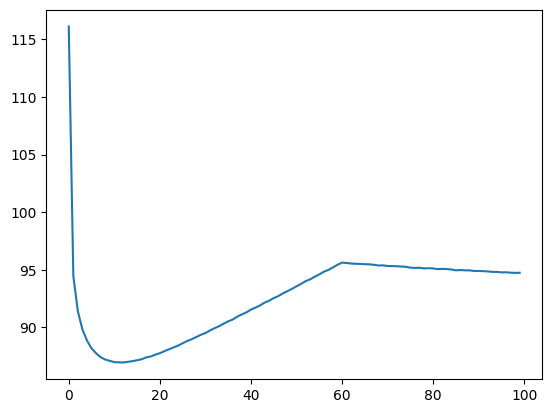

In [ ]:
plt.plot(np.array(losses_cnn_kl_warmup))

In [ ]:
with torch.no_grad():
  preds_cnn_klw = model(test_data.to(device).float()/255.0)

preds_cnn_klw_z = model.reparam(preds_cnn_klw[1], preds_cnn_klw[2])

In [ ]:
umap_dims = umap.UMAP().fit_transform(preds_cnn_klw_z.cpu().float())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
umap_dims = pd.DataFrame(umap_dims, columns = ['x','y'])

In [ ]:
umap_dims['clust'] = test_labels.numpy()
umap_dims['clust'] = umap_dims['clust'].astype('category')

<Axes: xlabel='x', ylabel='y'>

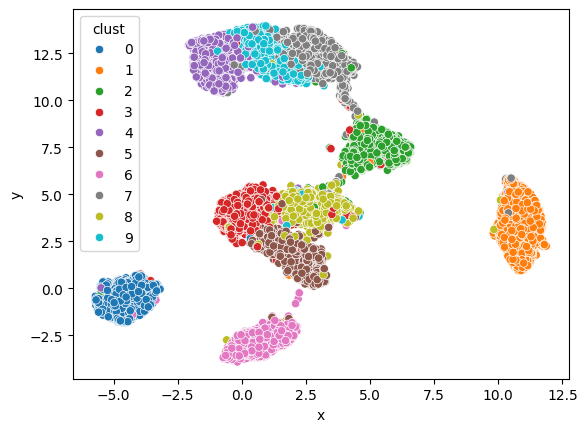

In [ ]:
sns.scatterplot(umap_dims, x='x', y='y', hue='clust')

In [ ]:
#define training params
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(z_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-3, lr = 0.002) #2x the learning rate

losses_cnn_kl_warmup2 = []

for epoch in range(0, epochs):
  loss = train_kl_warmup(input_data_loader=train_loader,
               model=model,
               optimizer=optimizer,
               device=device,
               epoch = epoch,
               total_epochs = epochs)

  losses_cnn_kl_warmup2.append(loss)

  # Visualize results every few epochs
  if epoch % 10 == 0:
    print(f'Epoch: {epoch+1}; loss: {loss}')

Epoch: 1; loss: 108.64038785807291
Epoch: 11; loss: 86.78103264363607
Epoch: 21; loss: 88.34459790039062
Epoch: 31; loss: 90.41702436828614
Epoch: 41; loss: 92.61645376078287
Epoch: 51; loss: 94.85639035542806
Epoch: 61; loss: 97.03973771158854
Epoch: 71; loss: 96.80095364379883
Epoch: 81; loss: 96.6296165262858
Epoch: 91; loss: 96.55509398396809


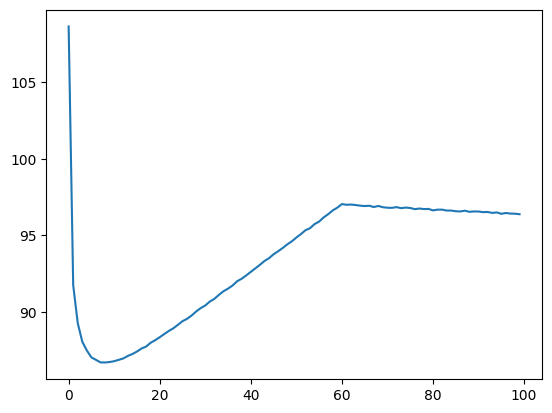

In [ ]:
plt.plot(np.array(losses_cnn_kl_warmup2))

In [ ]:
import pickle
pred_dict = {'vanilla':preds_z, 'vanilla_cnn':preds_cnn_z, 'vanilla_cnn_klw': preds_cnn_klw_z}

with open("/content/drive/MyDrive/single_cell/data/mnist_vae_outs.pkl","wb") as f:
  pickle.dump(pred_dict, f)